In [1]:
%load_ext autoreload
%autoreload 2

import os

# Load data

In [2]:
import torch
import numpy as np

emb_path = f"../data/Visium_FFPE_Human_Breast_Cancer/moco_embed_moco-TENXHB-rn50.pt"
embeddings_dict = torch.load(emb_path)
embeddings = []
    
for embedding in embeddings_dict.values():
    embeddings.append(embedding.numpy())

embeddings = np.array(embeddings)
embeddings[0].shape

(2048,)

In [3]:
image_path = "/home/luca/Documents/data/Visium_FFPE_Human_Breast_Cancer/image_dict_64.pt"
image_dict = torch.load(image_path)

In [4]:
import numpy as np
import json

hovernet_path = "/home/luca/Documents/data/Visium_FFPE_Human_Breast_Cancer/seg_json/pannuke_fast_mask_lvl3.json"
with open(hovernet_path) as json_file:
        data = json.load(json_file)
        hovernet_dict = data["nuc"]

labels = []
for cell_info in hovernet_dict.values():
    labels.append(cell_info['type'])
labels = np.array(labels)

# Perform Dimension Reduction

In [5]:
from utils import perform_umap

umap_embeddings = perform_umap(embeddings, n_neighbors=15, min_dist=0.1, n_components=2)

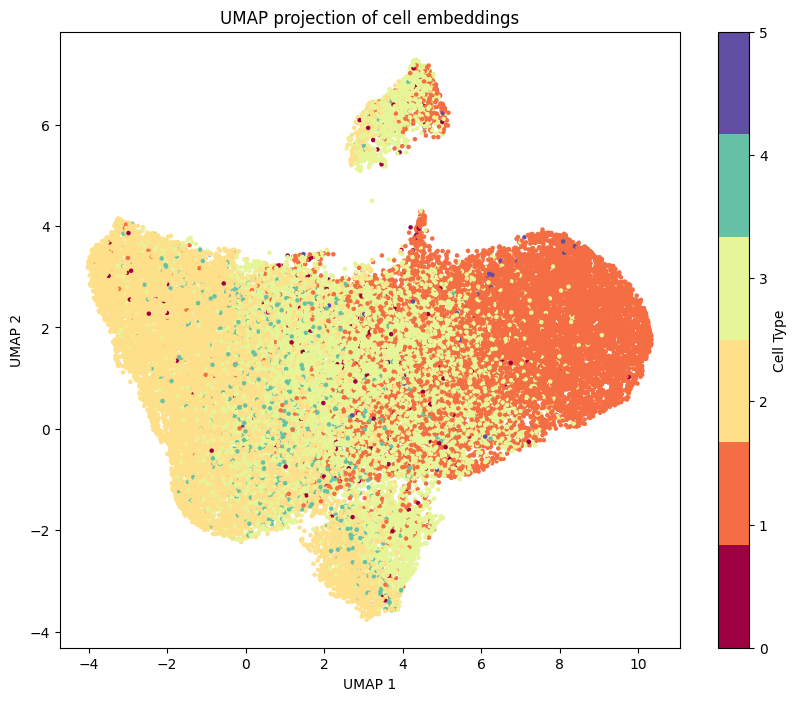

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
num_classes = len(np.unique(labels))
cmap = plt.get_cmap('Spectral', num_classes)
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels, cmap=cmap, s=5)
cbar = plt.colorbar(scatter, ticks=np.arange(num_classes))
cbar.set_label('Cell Type')

plt.title('UMAP projection of cell embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

In [103]:
from sklearn.preprocessing import StandardScaler

embeddings = StandardScaler().fit_transform(embeddings)

In [147]:
from sklearn.decomposition import PCA

n_components = 1024

pca = PCA(n_components=n_components)
pca_embeddings = pca.fit_transform(embeddings)

# Perform clustering

In [5]:
from utils import perform_kmeans

n_clusters = 4
metric = 'euclidean'
random_state = 42

cluster_labels, distances, centroids = perform_kmeans(embeddings, 
                                                      n_clusters=n_clusters, 
                                                      metric=metric, 
                                                      random_state=random_state)

In [6]:
from utils import find_closest_cells_to_clusters

num_per_cluster = 1000

selected_indices = find_closest_cells_to_clusters(cluster_labels, distances, num_per_cluster=num_per_cluster)

filtered_embeddings = embeddings[selected_indices]
# filtered_pca_embeddings = pca_embeddings[selected_indices]
# filtered_umap_embeddings = umap_embeddings[selected_indices]
filtered_labels = cluster_labels[selected_indices]
filtered_ids = np.array(list(image_dict.keys()))[selected_indices]

In [56]:
# filtered_embeddings = filtered_embeddings[np.where(filtered_labels != 1)]
# filtered_ids = filtered_ids[np.where(filtered_labels != 1)]
# filtered_labels = filtered_labels[np.where(filtered_labels != 1)]
# filtered_labels = np.where(filtered_labels == 2, 1, filtered_labels)
# filtered_labels = np.where(filtered_labels == 3, 2, filtered_labels)

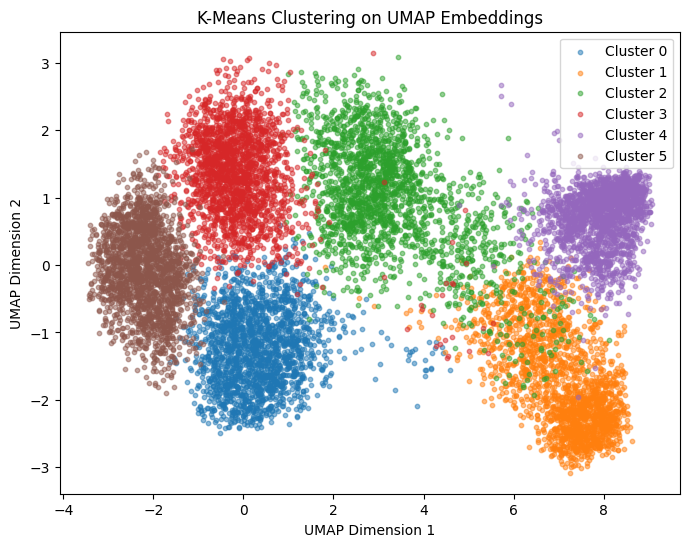

In [13]:
restricted = True

plt.figure(figsize=(8, 6))

for i in range(n_clusters):
    if restricted:
        plt.scatter(
            filtered_umap_embeddings[filtered_labels == i, 0], 
            filtered_umap_embeddings[filtered_labels == i, 1], 
            label=f'Cluster {i}', alpha=filtered_pca_embeddings = pca_embeddings[selected_indices]
# filtered_umap_embeddings = umap_embeddings[selected_indices]0.5, s=10
        )
    else:
        plt.scatter(
            umap_embeddings[cluster_labels == i, 0], 
            umap_embeddings[cluster_labels == i, 1], 
            label=f'Cluster {i}', alpha=0.5, s=10
        )

plt.legend()
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.title("K-Means Clustering on UMAP Embeddings")
plt.show()

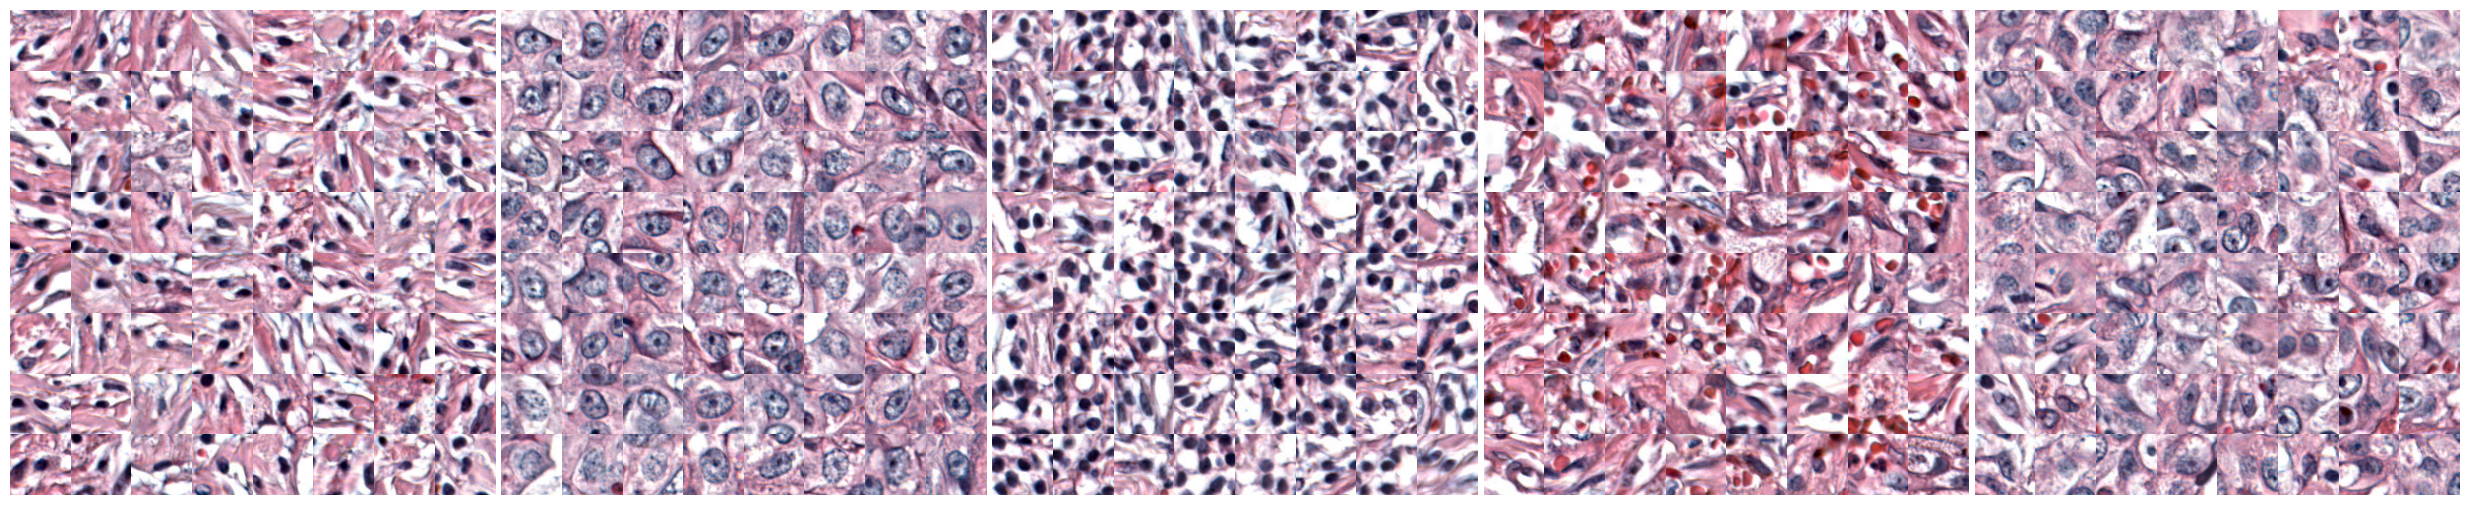

In [11]:
from utils import plot_cells_per_cluster

nrows = 1
ncols = 5
display = True

fig = plot_cells_per_cluster(image_dict,
                        filtered_ids,
                        filtered_labels,
                        selection="top",
                        nrows=nrows,
                        ncols=ncols,
                        display=display)
# fig.savefig("../deconv-plugin/benchmark/results/mhast/cluster_mosaic.png", dpi=300, bbox_inches="tight")

In [7]:
# add a new cluster identical to another one

cluster_to_duplicate = 0
n_clusters = len(np.unique(cluster_labels))
cluster_indices = np.where(filtered_labels == cluster_to_duplicate)[0]
duplicate_embeddings = filtered_embeddings[cluster_indices]
duplicate_ids = filtered_ids[cluster_indices]
duplicate_ids = np.char.add(duplicate_ids.astype(str), "-1")

filtered_embeddings = np.concatenate([filtered_embeddings, duplicate_embeddings], axis=0)
filtered_ids = np.concatenate([filtered_ids, duplicate_ids], axis=0)
filtered_labels = np.concatenate([filtered_labels, np.full(num_per_cluster, n_clusters)])

KeyError: '238612-1'

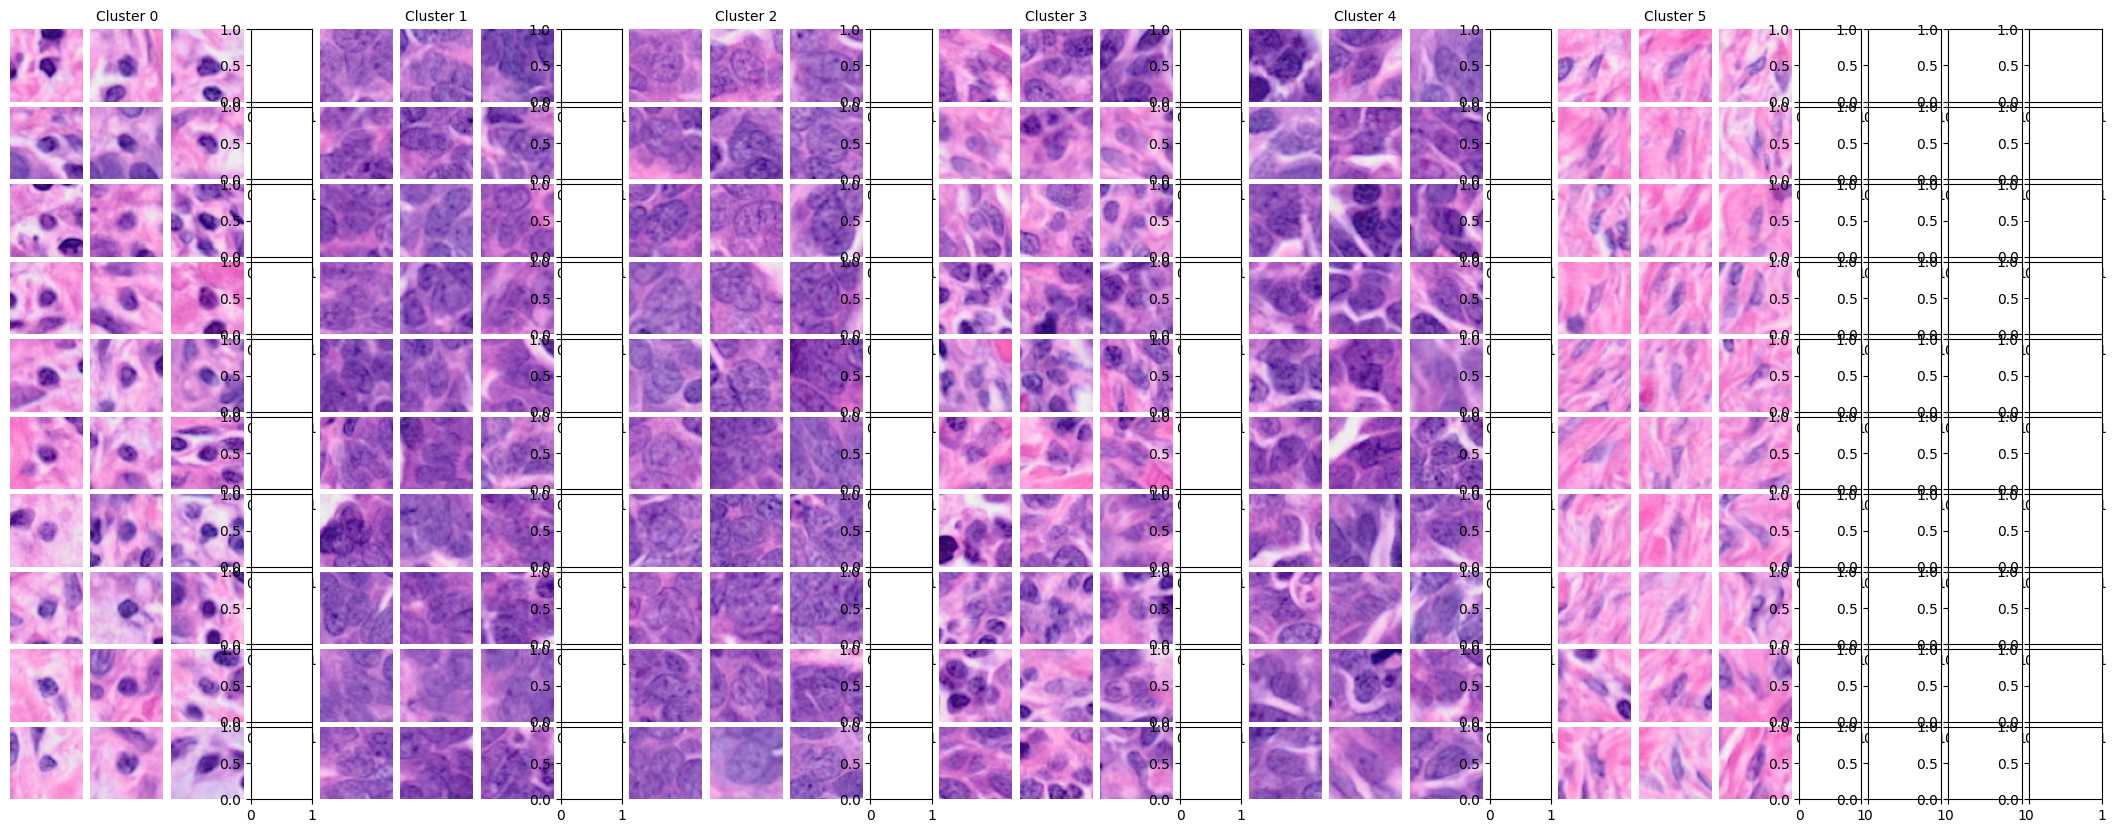

In [ ]:
from utils import plot_cells_per_cluster

nrows = 2
ncols = 2
display = True

plot_cells_per_cluster(image_dict,
                        filtered_ids,
                        filtered_labels,
                        selection="top",
                        nrows=nrows,
                        ncols=ncols,
                        display=display)

# Linear Regression

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


X = torch.stack([image_dict[i].flatten() for i in filtered_ids]).numpy()
y = np.array(filtered_labels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
clf = LogisticRegression(max_iter=1500, verbose=1)
clf.fit(X_train, y_train)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        86023     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94591D+00    |proj g|=  9.69032D+00


 This problem is unconstrained.



At iterate   50    f=  5.04394D-01    |proj g|=  9.09958D-01

At iterate  100    f=  4.50827D-01    |proj g|=  3.00169D+00

At iterate  150    f=  3.97085D-01    |proj g|=  5.14402D-01

At iterate  200    f=  3.70349D-01    |proj g|=  5.03923D-01

At iterate  250    f=  3.49625D-01    |proj g|=  3.23411D-01

At iterate  300    f=  3.32590D-01    |proj g|=  3.81014D-01

At iterate  350    f=  3.15207D-01    |proj g|=  2.94352D-01

At iterate  400    f=  3.01885D-01    |proj g|=  5.41396D-01

At iterate  450    f=  2.88391D-01    |proj g|=  3.63996D-01

At iterate  500    f=  2.73214D-01    |proj g|=  3.51624D-01

At iterate  550    f=  2.62836D-01    |proj g|=  2.88965D-01

At iterate  600    f=  2.50891D-01    |proj g|=  3.74882D-01

At iterate  650    f=  2.42110D-01    |proj g|=  2.82442D-01

At iterate  700    f=  2.30995D-01    |proj g|=  2.98763D-01

At iterate  750    f=  2.22755D-01    |proj g|=  1.45178D-01

At iterate  800    f=  2.15849D-01    |proj g|=  2.35140D-01

At iter

/home/luca/anaconda3/envs/plugin-env/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1500, verbose=1)

In [49]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Accuracy: 0.6493
              precision    recall  f1-score   support

           0       0.08      0.07      0.08       407
           1       0.80      0.82      0.81       398
           2       0.93      0.90      0.91       402
           3       0.86      0.86      0.86       396
           4       0.85      0.85      0.85       418
           5       0.95      0.93      0.94       386
           6       0.10      0.11      0.11       393

    accuracy                           0.65      2800
   macro avg       0.65      0.65      0.65      2800
weighted avg       0.65      0.65      0.65      2800



In [52]:
from sklearn.metrics import confusion_matrix
import pandas as pd

conf_matrix = confusion_matrix(y_test, y_pred)
pd.DataFrame(conf_matrix, columns=[f'Predicted {i}' for i in range(7)], index=[f'Actual {i}' for i in range(7)])

Predicted 0  Predicted 1  Predicted 2  Predicted 3  Predicted 4  \
Actual 0           30            0            0            0            0   
Actual 1            0          327           23            6           42   
Actual 2            0           41          360            0            1   
Actual 3            1           11            0          340           21   
Actual 4            0           31            3           27          357   
Actual 5            1            0            0           22            0   
Actual 6          347            0            0            0            0   

          Predicted 5  Predicted 6  
Actual 0            2          375  
Actual 1            0            0  
Actual 2            0            0  
Actual 3           15            8  
Actual 4            0            0  
Actual 5          360            3  
Actual 6            2           44

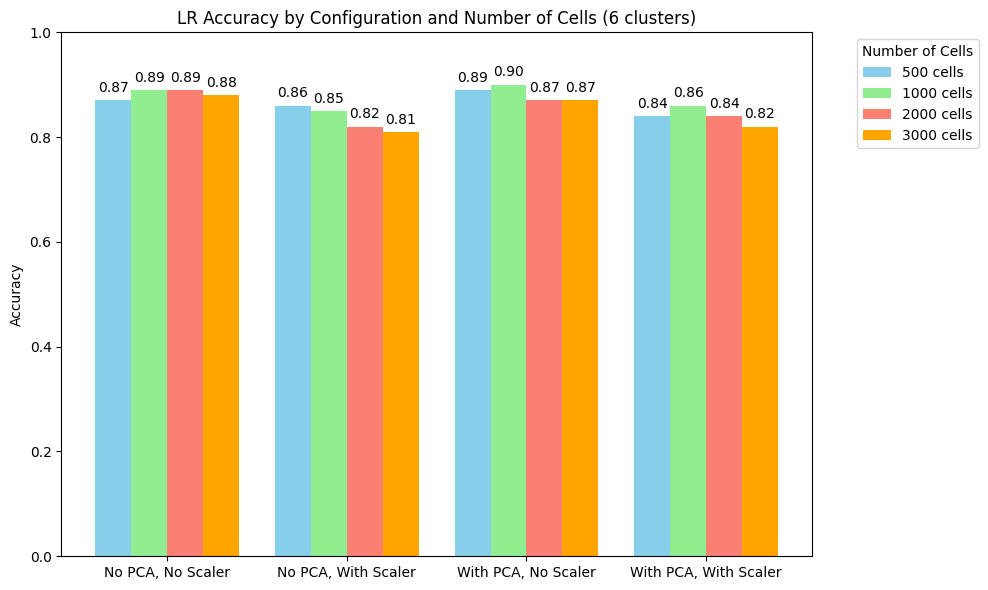

In [165]:
no_pca_no_scaler = [0.87, 0.89, 0.89, 0.88]
no_pca_with_scaler = [0.86, 0.85, 0.82, 0.81]
with_pca_no_scaler = [0.89, 0.9, 0.87, 0.87]
with_pca_with_scaler = [0.84, 0.86, 0.84, 0.82]

data = [no_pca_no_scaler, no_pca_with_scaler, with_pca_no_scaler, with_pca_with_scaler]

labels = ['No PCA, No Scaler', 'No PCA, With Scaler', 'With PCA, No Scaler', 'With PCA, With Scaler']

image_counts = [500, 1000, 2000, 3000]

colors = ['skyblue', 'lightgreen', 'salmon', 'orange']

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(len(image_counts)):
    bars = [data[j][i] for j in range(len(data))]
    rects = ax.bar(x + i * width, bars, width, label=f'{image_counts[i]} cells', color=colors[i])
    
    for rect in rects:
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2,
            height + 0.01,
            f'{height:.2f}',
            ha='center',
            va='bottom'
        )

ax.set_ylabel('Accuracy')
ax.set_title('LR Accuracy by Configuration and Number of Cells (6 clusters)')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
ax.legend(title='Number of Cells', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [113]:
# accuracies = []
# for num_per_cluster in [500, 1000, 2000, 3000]:
#     selected_indices = find_closest_cells_to_clusters(cluster_labels, distances, num_per_cluster=num_per_cluster)
#     filtered_embeddings = embeddings[selected_indices]
#     filtered_pca_embeddings = pca_embeddings[selected_indices]
#     filtered_umap_embeddings = umap_embeddings[selected_indices]
#     filtered_labels = cluster_labels[selected_indices]
#     filtered_ids = np.array(list(image_dict.keys()))[selected_indices]

#     X = torch.stack([image_dict[i].flatten() for i in filtered_ids]).numpy()
#     y = np.array(filtered_labels)

#     X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#     clf = LogisticRegression(max_iter=1500, verbose=1)
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
#     accuracy = accuracy_score(y_test, y_pred)
#     print(f"Predictions for {num_per_cluster} cells finished. Accuracy: {accuracy:.4f}")
#     accuracies.append(accuracy)

# Simulate Visium spots

## Create bags

In [17]:
from utils import create_bags

mean_cell_per_bag = 5
var_cell_per_bag = 5
balance = "auto" # xeniumlike = [3.5, 0.5, 22, 2, 0.5, 4.5, 2], [4.5, 0.5, 1, 2]
not_mixed = None

total_number_of_bags = 30

bags, n_cells_per_cluster = create_bags(filtered_ids, 
                                         filtered_labels, 
                                         mean_cell_per_bag=mean_cell_per_bag, 
                                         var_cell_per_bag=var_cell_per_bag, 
                                         balance=balance,
                                         total_number_of_bags=total_number_of_bags,
                                         not_mixed=not_mixed,
                                         random_state=random_state)

Using cluster proportions: [0.25 0.25 0.25 0.25]


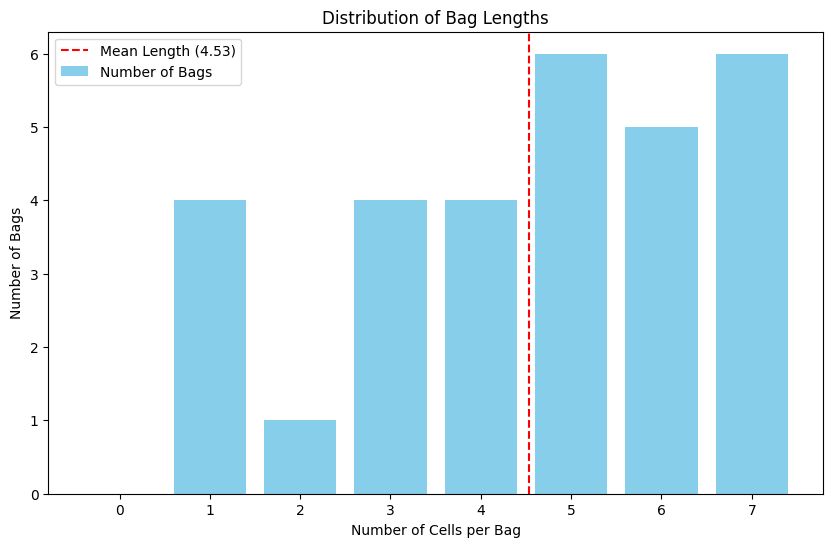

In [15]:
import matplotlib.pyplot as plt

bag_lengths = [len(bag) for bag in bags]
mean_length = np.mean(bag_lengths)

x_range = range(0, max(bag_lengths) + 1)
length_counts = [bag_lengths.count(x) for x in x_range]

plt.figure(figsize=(10, 6))
plt.bar(x_range, length_counts, color='skyblue', label='Number of Bags')
plt.axvline(x=mean_length, color='red', linestyle='--', label=f'Mean Length ({mean_length:.2f})')
plt.xlabel('Number of Cells per Bag')
plt.ylabel('Number of Bags')
plt.title('Distribution of Bag Lengths')
plt.xticks(x_range)
plt.legend()
plt.show()

/home/luca/Documents/simulation-embeddings/utils.py:327: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


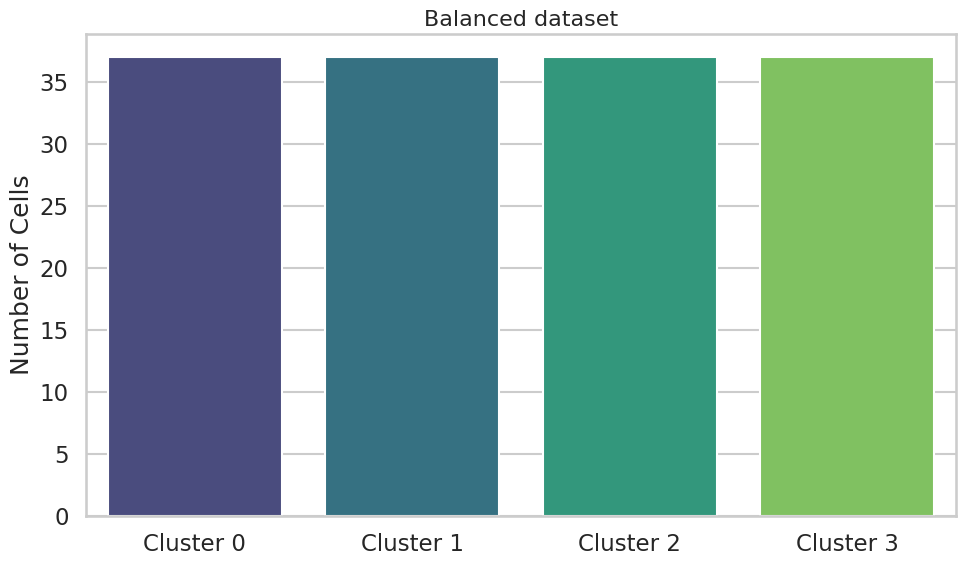

In [18]:
from utils import plot_cluster_distribution

plot_cluster_distribution(filtered_labels=filtered_labels, 
                              n_cells_per_cluster=n_cells_per_cluster, 
                              title='Balanced dataset',
                            #   savefig='../HEDeST/benchmark/results/mhast/Ovarian_Cancer_full_simulation/fig/distributions_reallike.png'
                            )

## Get bag proportions

In [19]:
from utils import get_bag_proportions

bag_proportions = get_bag_proportions(bags, filtered_ids, filtered_labels)

/home/luca/Documents/simulation-embeddings/utils.py:268: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bag_prop_df = bag_prop_df.fillna(0)


Figure saved to ../HEDeST/benchmark/results/mhast/Ovarian_Cancer_full_simulation/fig/bags_balanced.png


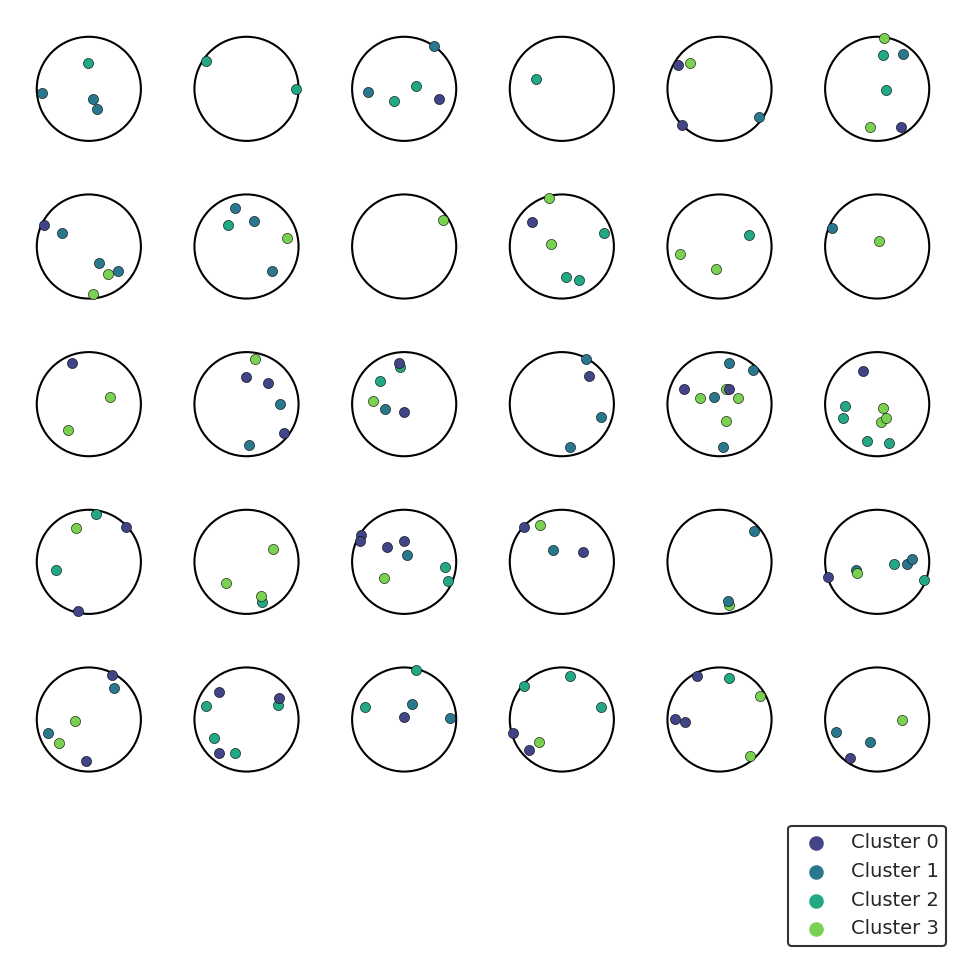

In [20]:
from utils import plot_bags

plot_bags(bags, 
           filtered_ids, 
           filtered_labels,
           fig_edge_size=10,
           savefig="../HEDeST/benchmark/results/mhast/Ovarian_Cancer_full_simulation/fig/bags_balanced.png")

# Save simulated data

In [14]:
output_path = "/home/luca/Documents/data/CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma/sim"
tag = "4_moco_clusters_30spots_reallike_5mean_5var"

## Spot proportions

In [15]:
filename = f"{tag}_prop.csv"
bag_proportions.to_csv(os.path.join(output_path, filename), index=True)

In [50]:
from utils import add_perturbation

strength = 0.5
bag_proportions_perturbed = add_perturbation(bag_proportions, strength=strength)

filename = f"{tag}_prop.csv"
bag_proportions_perturbed.to_csv(os.path.join(output_path, filename), index=True)

## Cell to spot dictionnary

In [16]:
from collections import defaultdict

spot_dict = defaultdict(list)
for spot_id, cell_list in enumerate(bags):
    spot_dict[str(spot_id)] = cell_list

In [17]:
filename = f"{tag}_spot_dict.json"
with open(os.path.join(output_path, filename), "w") as file:
    json.dump(dict(spot_dict), file)

## Reduced Image dictionnary

In [18]:
import re

def sort_key(cell_id):
    match = re.match(r"(\d+)(?:-(\d+))?", cell_id)
    if match:
        main_id = int(match.group(1))
        sub_id = int(match.group(2)) if match.group(2) else -1
        return (main_id, sub_id)
    return (float('inf'), float('inf'))

In [19]:
valid_cell_ids = {cell_id for cell_list in spot_dict.values() for cell_id in cell_list}
sorted_cell_ids = sorted(valid_cell_ids, key=sort_key)
filtered_image_dict = {
    cell_id: image_dict[cell_id.split('-')[0]]
    for cell_id in sorted_cell_ids
    if cell_id.split('-')[0] in image_dict
}

In [20]:
filename = f"{tag}_image_dict_64.pt"
torch.save(filtered_image_dict, os.path.join(output_path, filename))

## Reduced embedding dictionnary

In [21]:
reduced_emb = {
    cell_id: embeddings_dict[cell_id.split('-')[0]]
    for cell_id in filtered_image_dict
    if cell_id.split('-')[0] in embeddings_dict
}

In [22]:
filename = f"{tag}_emb_dict.pt"
torch.save(reduced_emb, os.path.join(output_path, filename))

## Ground Truth for each nucleus

In [23]:
import pandas as pd

ground_truth = pd.DataFrame(index=filtered_ids)
unique_clusters = np.unique(filtered_labels)

for cluster in unique_clusters:
    ground_truth[f'Cluster {cluster}'] = 0.0

for nucleus_id, cluster in zip(filtered_ids, filtered_labels):
    ground_truth.at[nucleus_id, f'Cluster {cluster}'] = 1.0

ground_truth = ground_truth[ground_truth.index.isin(valid_cell_ids)]
ground_truth.index.name = 'nucleus_id'

sorted_index = sorted(ground_truth.index, key=sort_key)
ground_truth = ground_truth.loc[sorted_index]
ground_truth.index = ground_truth.index.astype(str)
ground_truth

Cluster 0  Cluster 1  Cluster 2  Cluster 3
nucleus_id                                            
17900             0.0        0.0        0.0        1.0
29689             0.0        0.0        1.0        0.0
30444             0.0        1.0        0.0        0.0
31067             0.0        0.0        0.0        1.0
39003             0.0        0.0        0.0        1.0
...               ...        ...        ...        ...
349121            1.0        0.0        0.0        0.0
349186            1.0        0.0        0.0        0.0
349891            0.0        0.0        0.0        1.0
351000            1.0        0.0        0.0        0.0
351553            1.0        0.0        0.0        0.0

[136 rows x 4 columns]

In [24]:
filename = f"{tag}_gt.csv"
ground_truth.to_csv(os.path.join(output_path, filename), index=True)

# XGBoost Classification analysis

In [ ]:
import json

with open("xgb_metrics_unbalanced.json", "r") as f:
    data = json.load(f)

In [ ]:
import pandas as pd
ct_list = [
    "B cell", "Endothelial cell", "Epithelial cell", "Macrophage/Monocyte", 
    "Mast cell", "NK cell", "Neutrophils", "Plasma cell", 
    "Stromal", "T cell", "cDC", "pDC"
]

pd.DataFrame(data["Confusion Matrix"], columns=ct_list, index=ct_list)